In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from mapie.regression import MapieRegressor

from tspiral.model_selection import TemporalSplit
from tspiral.forecasting import ForecastingCascade, ForecastingChain

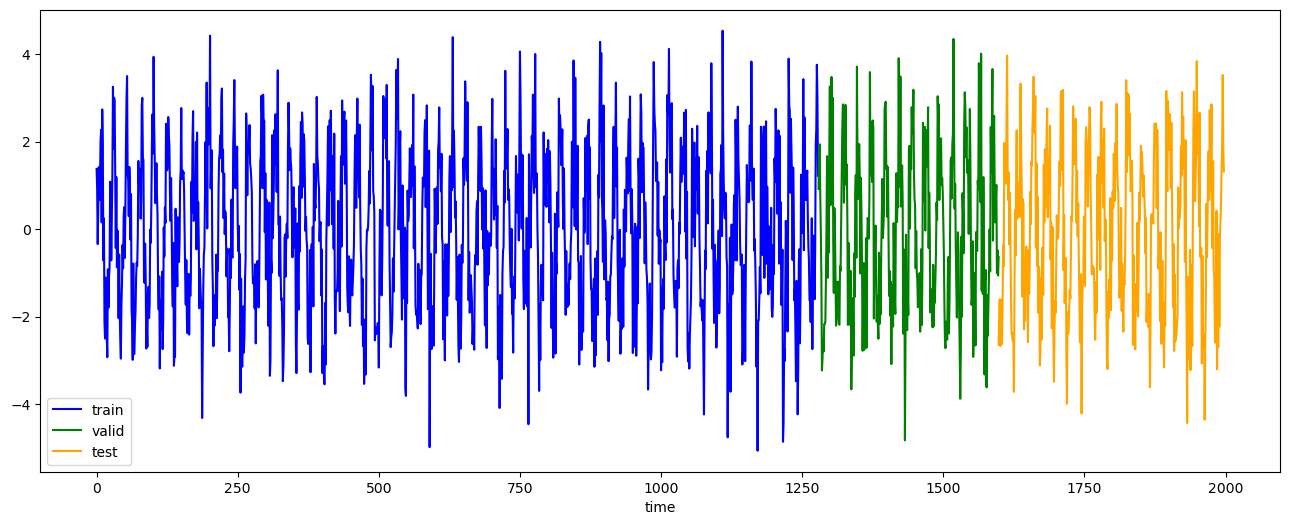

In [2]:
### SYNTETIC DATA GENERATION ###

timesteps = 2_000
e = np.random.normal(0,1, (timesteps,))
X = np.zeros((timesteps,1))
y = 2*np.sin(np.arange(timesteps)*(2*np.pi/24))+e

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False
)

train_range = range(0,len(y_train))
val_range = range(max(train_range),max(train_range)+len(y_val))
test_range = range(max(val_range),max(val_range)+len(y_test))

plt.figure(figsize=(16,6))
plt.plot(train_range, y_train, c='blue', label='train')
plt.plot(val_range, y_val, c='green', label='valid')
plt.plot(test_range, y_test, c='orange', label='test')
plt.xlabel('time'); plt.legend(); plt.show()

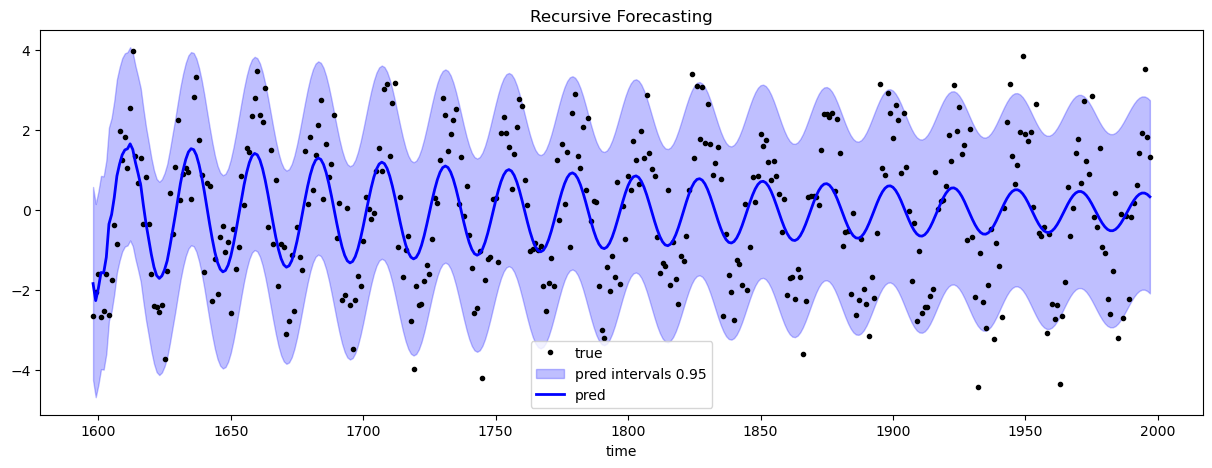

In [3]:
### CONFORMAL PREDICTION WITH RECURSIVE FORECASTING ###

forecaster = ForecastingCascade(
    Ridge(),
    lags=range(1,24+1),
    groups=[0],
)

forecaster.fit(X_train, y_train)
y_pred_val_rec = forecaster.predict(X_val)

model = MapieRegressor(
    forecaster, cv="prefit"
).fit(X_val, y_val)

forecaster.fit(X_train_val, y_train_val)
model.single_estimator_ = forecaster

y_pred_test_rec = model.predict(X_test, alpha=0.05)


plt.figure(figsize=(15,5))
plt.plot(test_range, y_test, '.k', label='true')
plt.fill_between(test_range, y_pred_test_rec[1][:, 0, 0], y_pred_test_rec[1][:, 1, 0], 
                 alpha=0.25, color='blue', label='pred intervals 0.95')
plt.plot(test_range, y_pred_test_rec[0], 'blue', linewidth=2, label='pred')
plt.title('Recursive Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()

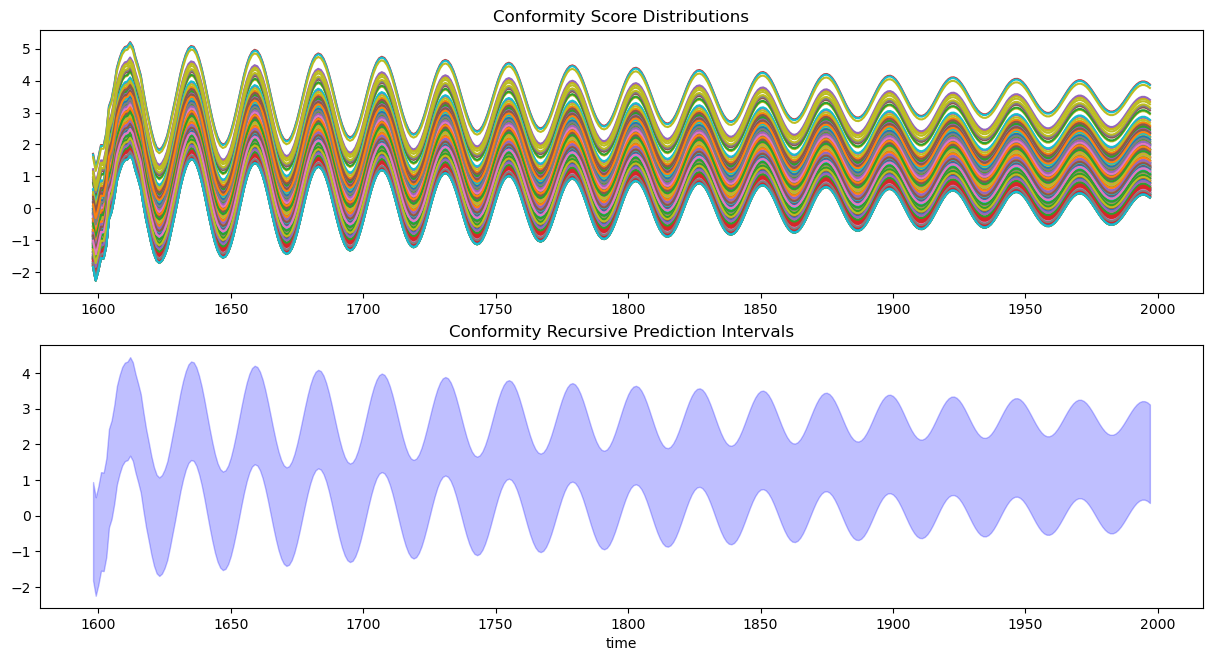

In [4]:
### HOW CONFORMITY SCORES ARE GENERATED WITH RECURSIVE FORECASTING ###

alpha = 0.95
conformity_scores = np.abs(np.subtract(y_val, y_pred_val_rec))
estimated_distributions = np.add(y_pred_test_rec[0][:, None], conformity_scores)

lower_q, upper_q = np.quantile(
    estimated_distributions, 
    [(1-alpha)/2, 1-(1-alpha)/2], axis=1
)


plt.figure(figsize=(15,7.5))
plt.subplot(2,1,1)
plt.plot(test_range, estimated_distributions)
plt.title('Conformity Score Distributions')
plt.subplot(2,1,2)
plt.fill_between(test_range, lower_q, upper_q, alpha=0.25, color='blue')
plt.title('Conformity Recursive Prediction Intervals')
plt.xlabel('time')
plt.show()

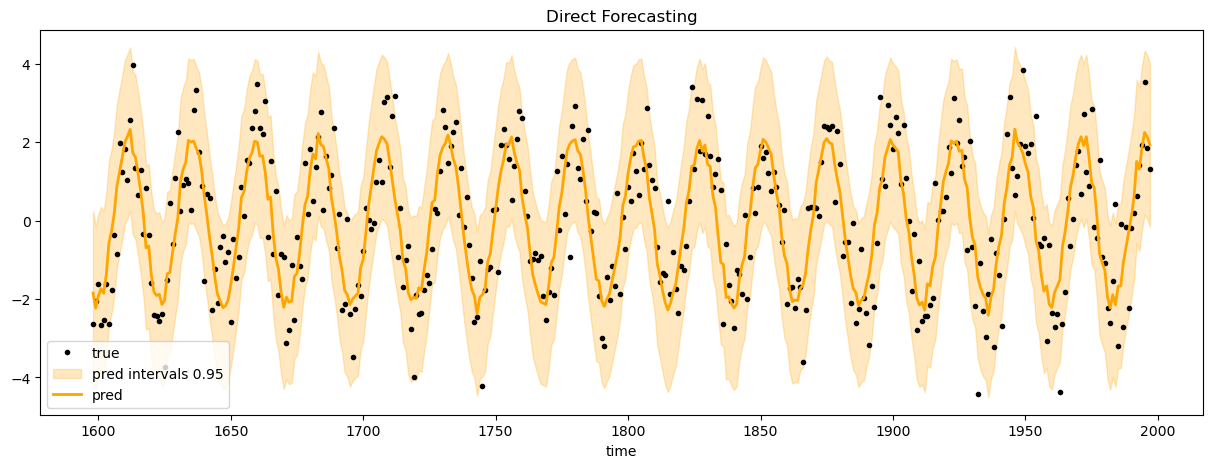

In [5]:
### CONFORMAL PREDICTION WITH DIRECT FORECASTING ###

forecaster = ForecastingChain(
    Ridge(),
    n_estimators=len(y_test),
    lags=range(1,24+1),
    groups=[0]
)

forecaster.fit(X_train, y_train)
y_pred_val_dir = forecaster.predict(X_val)

model = MapieRegressor(
    forecaster, cv="prefit"
).fit(X_val, y_val)

forecaster.fit(X_train_val, y_train_val)
model.single_estimator_ = forecaster

y_pred_test_dir = model.predict(X_test, alpha=0.05)


plt.figure(figsize=(15,5))
plt.plot(test_range, y_test, '.k', label='true')
plt.fill_between(test_range, y_pred_test_dir[1][:, 0, 0], y_pred_test_dir[1][:, 1, 0], 
                 alpha=0.25, color='orange', label='pred intervals 0.95')
plt.plot(test_range, y_pred_test_dir[0], 'orange', linewidth=2, label='pred')
plt.title('Direct Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()

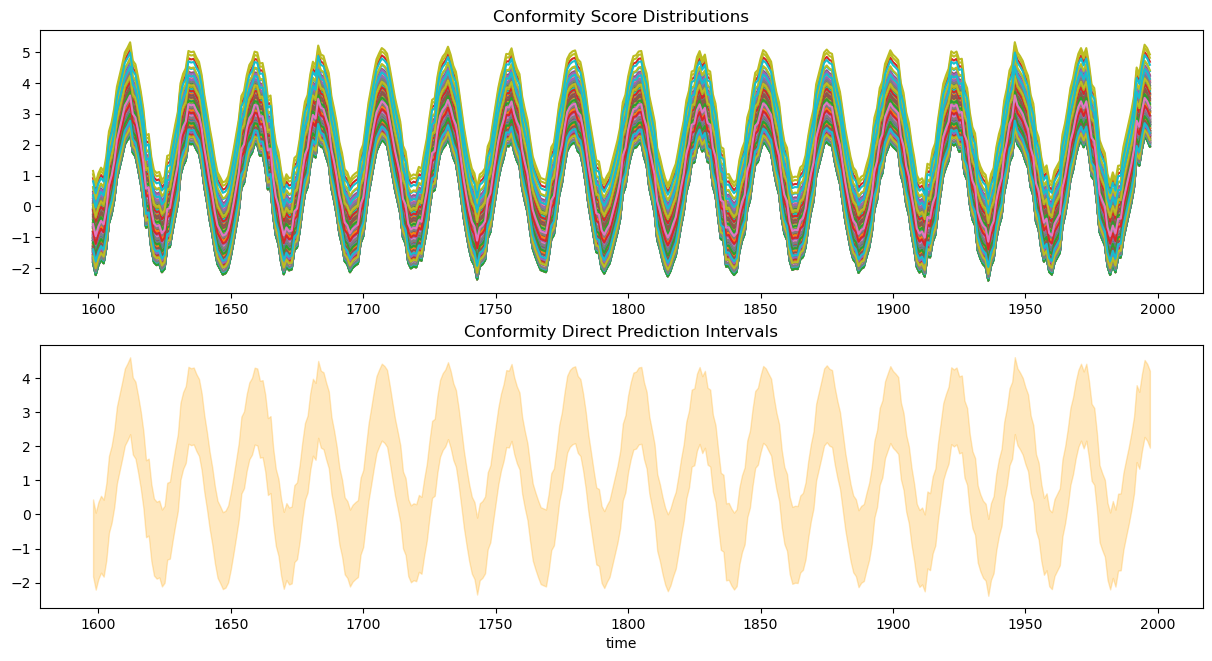

In [6]:
### HOW CONFORMITY SCORES ARE GENERATED WITH DIRECT FORECASTING ###

conformity_scores = np.abs(np.subtract(y_val, y_pred_val_dir))
estimated_distributions = np.add(y_pred_test_dir[0][:, None], conformity_scores)

lower_q, upper_q = np.quantile(
    estimated_distributions, 
    [(1-alpha)/2, 1-(1-alpha)/2], axis=1
)


plt.figure(figsize=(15,7.5))
plt.subplot(2,1,1)
plt.plot(test_range, estimated_distributions)
plt.title('Conformity Score Distributions')
plt.subplot(2,1,2)
plt.fill_between(test_range, lower_q, upper_q, alpha=0.25, color='orange')
plt.title('Conformity Direct Prediction Intervals')
plt.xlabel('time')
plt.show()

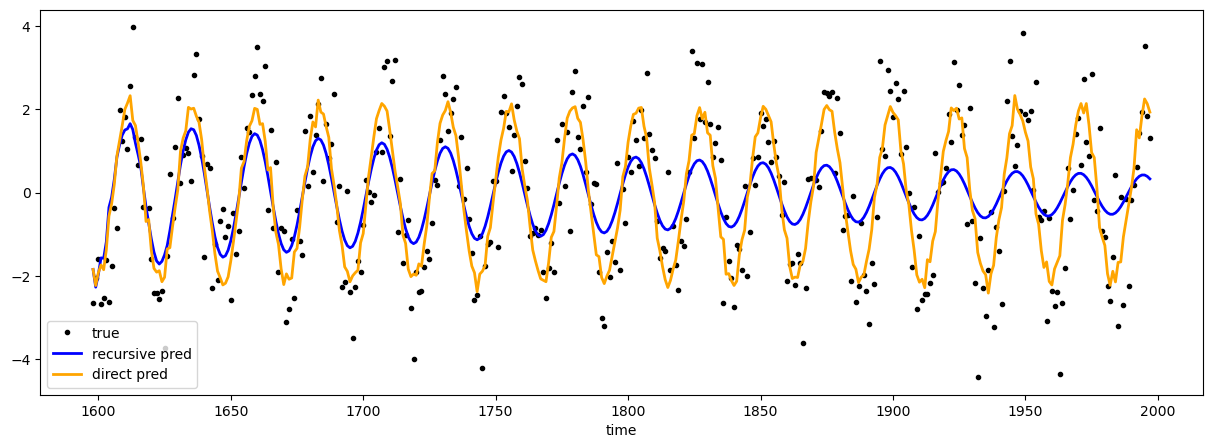

In [7]:
### COMPARING FORECASTING TECHNIQUES ###

plt.figure(figsize=(15,5))
plt.plot(test_range, y_test, '.k', label='true')
plt.plot(test_range, y_pred_test_rec[0], 'blue', linewidth=2, label='recursive pred')
plt.plot(test_range, y_pred_test_dir[0], 'orange', linewidth=2, label='direct pred')
plt.xlabel('time'); plt.legend()
plt.show()

C:\Users\marco.cerliani\.conda\envs\general\Lib\site-packages\mapie\utils.py:453: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
C:\Users\marco.cerliani\.conda\envs\general\Lib\site-packages\mapie\aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


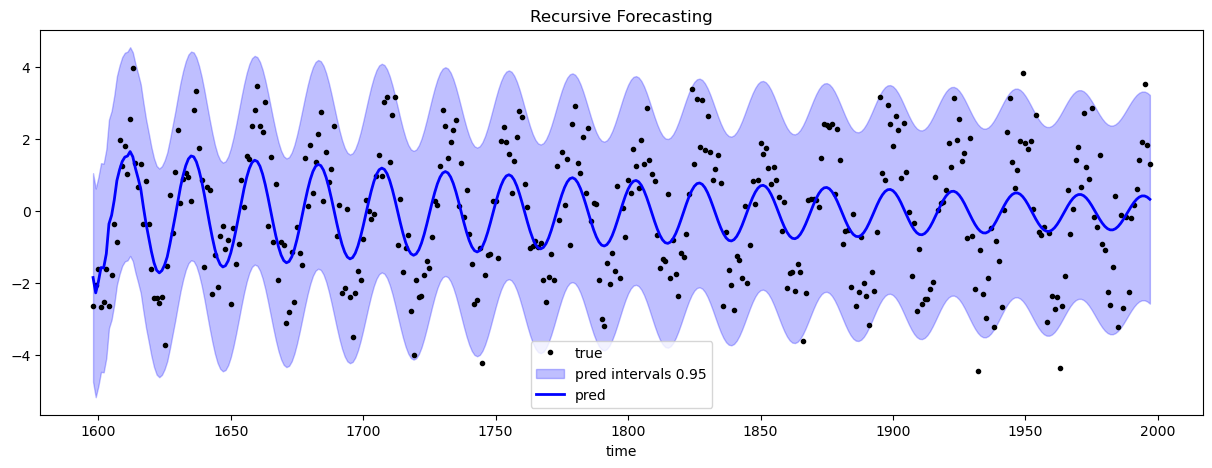

In [8]:
### CONFORMAL PREDICTION WITH RECURSIVE FORECASTING AND CV ###

forecaster = ForecastingCascade(
    Ridge(),
    lags=range(1,24+1),
    groups=[0],
)

model = MapieRegressor(
    forecaster, 
    cv=TemporalSplit(20, test_size=len(y_test)),
    method='base', agg_function=None, n_jobs=-1
).fit(X_train_val, y_train_val)

y_pred_test_rec = model.predict(X_test, alpha=0.05, ensemble=False)
# warning rises only because TemporalSplit generate not complete data partitions
# don't worry. it's enough to generate conformity scores. NaNs are automatically removed by MAPIE


plt.figure(figsize=(15,5))
plt.plot(test_range, y_test, '.k', label='true')
plt.fill_between(test_range, y_pred_test_rec[1][:, 0, 0], y_pred_test_rec[1][:, 1, 0], 
                 alpha=0.25, color='blue', label='pred intervals 0.95')
plt.plot(test_range, y_pred_test_rec[0], 'blue', linewidth=2, label='pred')
plt.title('Recursive Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()

C:\Users\marco.cerliani\.conda\envs\general\Lib\site-packages\mapie\utils.py:453: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
C:\Users\marco.cerliani\.conda\envs\general\Lib\site-packages\mapie\aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


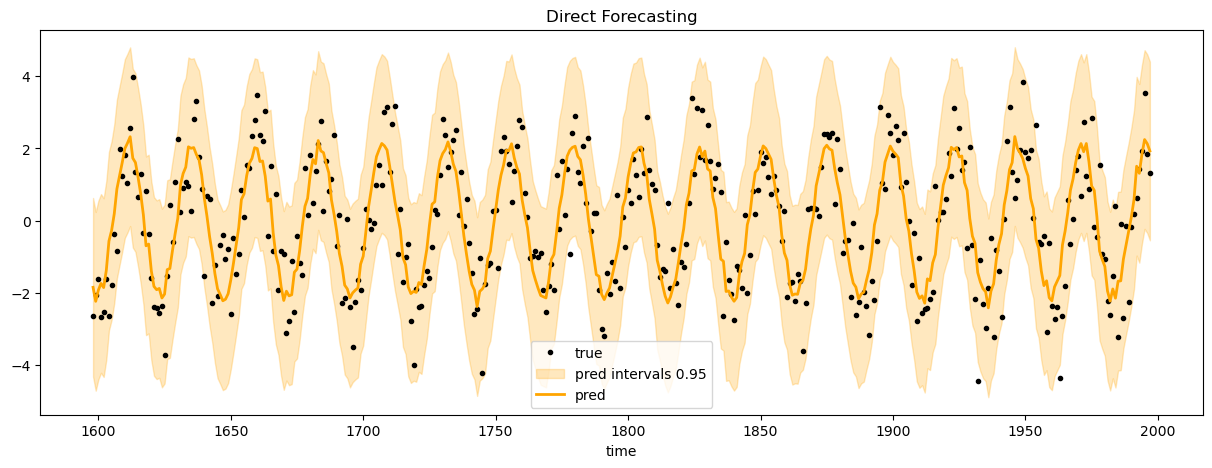

In [9]:
### CONFORMAL PREDICTION WITH DIRECT FORECASTING AND CV ###

forecaster = ForecastingChain(
    Ridge(),
    n_estimators=len(y_test),
    lags=range(1,24+1),
    groups=[0]
)

model = MapieRegressor(
    forecaster, 
    cv=TemporalSplit(20, test_size=len(y_test)),
    method='base', agg_function=None, n_jobs=-1
).fit(X_train_val, y_train_val)

y_pred_test_dir = model.predict(X_test, alpha=0.05, ensemble=False)
# warning rises only because TemporalSplit generate not complete data partitions
# don't worry. it's enough to generate conformity scores. NaNs are automatically removed by MAPIE


plt.figure(figsize=(15,5))
plt.plot(test_range, y_test, '.k', label='true')
plt.fill_between(test_range, y_pred_test_dir[1][:, 0, 0], y_pred_test_dir[1][:, 1, 0], 
                 alpha=0.25, color='orange', label='pred intervals 0.95')
plt.plot(test_range, y_pred_test_dir[0], 'orange', linewidth=2, label='pred')
plt.title('Direct Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()